# Project: What does the data say about AirBnB in Austin.

In this project, I used the CRISP-DM Process to analyse Austin Airbnb data from September 18, 2019 to October 8, 2020. The data is sources from the following website https://www.kaggle.com/datasets/clnguyen/austinairbnbs20191112 
The questions I want to explore using this dataset are the following:

1. Is there any seasonal variability in prices and room availability?
2. What are the busiest time of the year to visit Austin?
3. Are there properties of the listing associated with high price?
4. Can we predict accomodation price using listing features.

I answer these questions, by understanding and preparing the data, model the data, and deploy the result to Medium.

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

## Step 0: Load the Data
There are three files that we will be using for this project:

* `listings_full.csv`: this contains data about all unique listings in Austin for the time period. It is of size 11339 listings (rows) $\times$ 106 features (columns).

* `calendar.csv`: this contains the calendar for listings listed for each day within the time period. It is of size 4138735 calendar listings (rows) $\times$ 7 features (columns).

* `reviews_full.csv`: this contains the written review of people who stayed in one of the listings for the time period. It is of size 328902 number of reviews (rows) $\times$ 6 features (columns). The analysis of `reviews_full.csv` will require a good knowledge of text-mining. I am not yet proficient in that, therefore I woulld not be using this data in this project.

In [3]:
# Here we load each of our dataset.
df_listing = pd.read_csv('./listings_full.csv')
df_calendar = pd.read_csv('./calendar.csv')
df_reviews = pd.read_csv('./reviews_full.csv')

/Users/gideonidumah/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (43,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2265,https://www.airbnb.com/rooms/2265,20190919050302,2019-09-19,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.19
1,5245,https://www.airbnb.com/rooms/5245,20190919050302,2019-09-19,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07
2,5456,https://www.airbnb.com/rooms/5456,20190919050302,2019-09-19,"Walk to 6th, Rainey St and Convention Ctr",Fabulous location for walking to Convention Ce...,Cute Private Studio apartment located in Willo...,Fabulous location for walking to Convention Ce...,none,My neighborhood is ideally located if you want...,...,f,f,strict_14_with_grace_period,f,t,1,1,0,0,3.89
3,5769,https://www.airbnb.com/rooms/5769,20190919050302,2019-09-19,NW Austin Room,NaN,Looking for a comfortable inexpensive room to ...,Looking for a comfortable inexpensive room to ...,none,Quiet neighborhood with lots of trees and good...,...,f,f,moderate,t,t,1,0,1,0,2.20
4,6413,https://www.airbnb.com/rooms/6413,20190919050302,2019-09-19,Gem of a Studio near Downtown,"Great studio apartment, perfect for couples or...","(License #114332) Large, contemporary studio a...","Great studio apartment, perfect for couples or...",none,Travis Heights is one of the oldest neighborho...,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.84


In [5]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,320435,2019-09-19,t,$625.00,$625.00,4,7
1,320161,2019-09-19,f,$45.00,$45.00,30,365
2,320161,2019-09-20,f,$45.00,$45.00,30,365
3,320161,2019-09-21,f,$45.00,$45.00,30,365
4,320161,2019-09-22,f,$45.00,$45.00,30,365


In [6]:
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2265,963,2009-03-17,7538,Niall,I stayed here during SXSW and had a really ple...
1,2265,1057,2009-03-22,10029,Michael,"Great place, close enough to everything downto..."
2,2265,200418,2011-03-16,61677,Gustaf,We had a great time in Austin staying at Paddy...
3,2265,1001630,2012-03-15,1523753,Noah,We had a great stay at Zen East for South By S...
4,2265,1016390,2012-03-19,1547660,Melissa,I arrived late in the evening so did not meet ...


In [7]:
print(f'The number of unique listings in Austin between 09/18/2019 - 08/08/2020 is {df_listing.shape[0]}, and there are {df_listing.shape[1]} features.', "\n")

The number of unique listings in Austin between 09/18/2019 - 08/08/2020 is 11339, and there are 106 features. 



In [8]:
print(f'The number of calendar listings in Austin between 09/18/2019 - 08/08/2020 is {df_calendar.shape[0]}, and there are {df_calendar.shape[1]} features.', "\n")

The number of calendar listings in Austin between 09/18/2019 - 08/08/2020 is 4138735, and there are 7 features. 



## Step 1: Preprocessing

### Step 1.1: Reformat date to year and month in `df_calendar`

We begin by reformating the date form which is given as YY-MM-DD in `df_calendar` to a more convenient format. To do this, we create two new columns, month and year which are extracted from the date. 

Then we check if there are any missing values in the dataframe and decide what to do if there are any. Another preprocessing step for `df_calendar` is to change the *available* feature from **t,f** to **0,1**. This will be useful in future analysis.

The *price* feature is not formatted correctly. It has the $ sign in front of it, and it is also given in string. As part of the preprocessing process, I reformat that column into a float. I don't use the *adjusted_price* column, but I reformat it the same way as *price*.

Lasting for this dataframe, for ease of reading, we change dates months fro just numeric representation to abbreviated string representation. 

In [9]:
# create a new column for month and year from date attribute
df_calendar['year'] = pd.DatetimeIndex(df_calendar['date']).year
df_calendar['month'] = pd.DatetimeIndex(df_calendar['date']).month

In [10]:
# check if there are any missing values in calendar dataframe
df_calendar.isnull().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
year              0
month             0
dtype: int64

In [11]:
available_to_numeric = {'t': 1, 'f':0}
df_calendar['available'] = df_calendar['available'].map(available_to_numeric)

In [12]:
month_to_string = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
                   6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct',
                   11: 'Nov', 12: 'Dec'}
df_calendar['month'] = df_calendar['month'].map(month_to_string)

In [13]:
df_calendar['month'].value_counts()

Dec    351509
Jan    351509
Mar    351509
May    351509
Jul    351509
Aug    351509
Oct    351508
Nov    340170
Apr    340170
Jun    340170
Sep    328832
Feb    328831
Name: month, dtype: int64

In [14]:
# We remove the $ sign in front of the prices, and convert from string to float.
df_calendar['price'] = df_calendar['price'].apply(lambda x: float(x.strip('$').replace(',', '')))
df_calendar['adjusted_price'] = df_calendar['adjusted_price'].apply(lambda x: float(x.strip('$').replace(',', '')))

In [15]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,year,month
0,320435,2019-09-19,1,625.0,625.0,4,7,2019,Sep
1,320161,2019-09-19,0,45.0,45.0,30,365,2019,Sep
2,320161,2019-09-20,0,45.0,45.0,30,365,2019,Sep
3,320161,2019-09-21,0,45.0,45.0,30,365,2019,Sep
4,320161,2019-09-22,0,45.0,45.0,30,365,2019,Sep


### Step 1.2:  Preprocessing on `df_listings.csv`

This is a data set with $106$ columns, many of which will contains lots of zeros, and some which the entries will not be useful for our analysis. We do some preliminary checks on the number of missing values for each columns, and set a threshold for the maximum percentage of missing values to be allowed before a column is dropped. We also drop some unuseful columns that does not contain any useful information for our analysis.

For some of these, I will provide my justification for dropping them, why some will be obvious.

#### Step 1.2.1: Dropping irrelevant columns

In [16]:
df = df_listing.copy()
df.shape

(11339, 106)

In [17]:
# We perform an assessment of how much missing data is in each column
df_column_nan = df.isna().mean().sort_values(ascending=False)*100

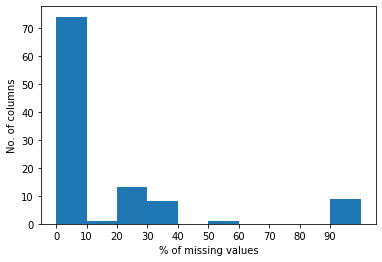

In [18]:
# Histogram of amount of missing data
plt.hist(df_column_nan)
plt.xticks(np.arange(0,100,10), [str(x) for x in np.arange(0,100,10)])
plt.xlabel('% of missing values')
plt.ylabel('No. of columns');

Comment:

From the histogram, we see that the outliers have more than $40%$ of missing values. Therefore, as a first step, we drop all columns that have more than this percentage of missing values

In [19]:
# As a first step we check for columns with more than 40% of NaNs
removed_columns_1 = df_column_nan[df_column_nan > 40].index
removed_columns_1

Index(['neighbourhood_group_cleansed', 'thumbnail_url', 'xl_picture_url',
       'medium_url', 'host_acceptance_rate', 'license', 'square_feet',
       'monthly_price', 'weekly_price', 'notes'],
      dtype='object')

In [20]:
# drop columns with more than 40% Nan
df.drop(removed_columns_1, axis=1, inplace=True)

In [21]:
# We check for columns with just one unique entry and drop them, as they are not useful for the analysis
nunique_listings = df.nunique(axis=0).sort_values(ascending=False)

In [22]:
removed_columns_2 = nunique_listings[nunique_listings == 1].index
removed_columns_2

Index(['requires_license', 'jurisdiction_names', 'scrape_id',
       'is_business_travel_ready', 'country_code', 'country',
       'has_availability', 'experiences_offered'],
      dtype='object')

In [23]:
# drop columns with same entries
df.drop(removed_columns_2, axis=1, inplace=True)

In [24]:
# Next we check for categorical variables with more than 10 categories
categorical_features = df.select_dtypes(include=['object']).columns

In [25]:
dropped_categorical = []
for label in categorical_features:
    try:
        if len(df[label].dropna().unique()) > 10:
            dropped_categorical.append(label)               
    except KeyError:
        pass
    
print(dropped_categorical)
len(dropped_categorical)

['listing_url', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'transit', 'access', 'interaction', 'house_rules', 'picture_url', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_rate', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'street', 'neighbourhood', 'city', 'zipcode', 'smart_location', 'property_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'extra_people', 'calendar_updated', 'first_review', 'last_review']


35

#### Comments:

We need to be careful before we drop these columns as some of them may actually be 'floats', which are written as strings. Therefore, I will manually check each one of them to be sure that they actually need to be dropped. Out of the 35 features with more than 10 categories, we drop 26 columns and do not drop 9 columns are explained below.

From my anaysis, the following **will not** be dropped as they actually can be converted to floats.

1. `host_since`: Can be made into a column of year
2. `host_response_rate`: Can be converted to floats
3. `host_verifications`: Can be turned to a continuous feature by counting the number of verifications required for each listing.
4. `property_type`: Can be turned to a categorical feature by turning some catgories to *Others*.
5. `amenities`: Can be turned to a continuous feature by counting the number of amentities for each listing.
6. `price`: Can be converted to floats.
7. `security_deposit`: Can be converted to floats.
8. `cleaning_fee`: Can be converted to floats.
9. `extra_people`: Can be converted to floats.

However, the following columns **will** be dropped. I will also give a brief explanation why I think so.

* `listing_url`, `picture_url`, `host_url`, `host_thumbnail_url`, `host_picture_url`: These are just URL's that provide no information.
* `name`, `summary`, `space`, `description`, `neighborhood_overview`, `transit`, `access`, `interaction`, `house_rules`, `host_about`: These are just bunch of texts. 
* `host_name`, `first_review`, `last_review`: obviously not relevant. 
* `host_neighbourhood`, `neighbourhood`, `zipcode`, `calendar_updated`: too much categories
* `street`, `city`, `smart_location`, `host_location`: one category has a very huge count.

In [26]:
# Next we drop columns that obviously do not contain any relevant information.
df.drop(['listing_url', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 
         'transit', 'access', 'interaction', 'house_rules', 'picture_url', 'host_url', 'host_name', 
         'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 
         'host_neighbourhood', 'street', 'neighbourhood', 'city', 'zipcode', 
         'smart_location', 'calendar_updated', 'first_review', 'last_review'], axis=1, inplace=True)

#### Comments:

There are still some columns which are not useful which still need to be dropped. We list them here, with a brief explanation to why they will be dropped.

* `last_scraped`, `host_id`, `state`, `market`, `latitude`, `longitude`, `calendar_last_scraped`, `neighbourhood_cleansed` : These columns do not also provide any releveant information

Note that `id` is a column that should be dropped also. But we still need it to answer some questions before doing regression. We will drop it later.


In [27]:
removed_columns_3 = ['last_scraped', 'host_id', 'state', 'market', 'latitude', 'longitude', 
                     'neighbourhood_cleansed', 'calendar_last_scraped']
df.drop(removed_columns_3, axis=1, inplace=True)

In [28]:
df.columns

Index(['id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'revi

In [29]:
df.shape

(11339, 54)

#### Step 1.2.2: Reformat columns in `df_listings`

In this subsection, we reformat some of the columns we do not drop.

In [30]:
# Change host_since to just year
df['host_since'] = pd.DatetimeIndex(df['host_since']).year
df['host_since'].value_counts()

2015.0    1801
2016.0    1707
2014.0    1611
2017.0    1452
2013.0    1337
2012.0    1103
2018.0     942
2011.0     672
2019.0     508
2010.0     147
2009.0      48
2008.0       6
Name: host_since, dtype: int64

#### Comments:

The number of categories in the reformated `host_since` is a little too much. So we perform the following further analysis.

In [31]:
host_since_map = {2008.0: '08-09', 2009.0: '08-09', 2010.0: '10-11', 2011.0: '10-11',
                 2012: '12-13', 2013: '12-13', 2014: '14-15', 2015: '14-15', 
                  2016: '16-17', 2017: '16-17', 2018: '18-19', 2019: '18-19'}
df['host_since'] = df['host_since'].map(host_since_map)

In [32]:
df['host_since'].value_counts()

14-15    3412
16-17    3159
12-13    2440
18-19    1450
10-11     819
08-09      54
Name: host_since, dtype: int64

In [33]:
# We remove the % in front of the numbers in host_response_rate and convert to float.
df['host_response_rate'].value_counts()[:5]

100%    6012
99%      382
98%      229
90%      225
97%      115
Name: host_response_rate, dtype: int64

In [34]:
df['host_response_rate'] = df['host_response_rate'].apply(lambda x: float(str(x).strip('%')))
df['host_response_rate'].value_counts()

100.0    6012
99.0      382
98.0      229
90.0      225
97.0      115
0.0        87
80.0       64
94.0       49
50.0       45
91.0       45
67.0       41
88.0       38
89.0       33
96.0       33
82.0       26
92.0       24
81.0       22
60.0       20
83.0       19
70.0       18
85.0       18
75.0       18
93.0       16
86.0       14
95.0       13
33.0       11
77.0        9
79.0        8
40.0        7
71.0        5
73.0        5
25.0        5
64.0        5
62.0        4
63.0        4
57.0        4
56.0        3
61.0        3
78.0        3
74.0        2
31.0        2
87.0        2
43.0        2
42.0        2
22.0        1
29.0        1
47.0        1
20.0        1
84.0        1
55.0        1
44.0        1
17.0        1
76.0        1
13.0        1
65.0        1
Name: host_response_rate, dtype: int64

In [35]:
# We turn host_verifications to a continuous variable
df['host_verifications']

0         ['email', 'phone', 'facebook', 'reviews', 'kba']
1         ['email', 'phone', 'facebook', 'reviews', 'kba']
2                     ['email', 'phone', 'reviews', 'kba']
3        ['email', 'phone', 'reviews', 'jumio', 'govern...
4        ['email', 'phone', 'reviews', 'jumio', 'offlin...
                               ...                        
11334                                   ['email', 'phone']
11335                                 ['phone', 'reviews']
11336                                   ['email', 'phone']
11337                 ['email', 'phone', 'reviews', 'kba']
11338    ['email', 'phone', 'offline_government_id', 'g...
Name: host_verifications, Length: 11339, dtype: object

In [36]:
df['host_verifications'] = df['host_verifications'].apply(lambda x: len(list(x.split(',')))) 
df['host_verifications']

0        5
1        5
2        4
3        6
4        8
        ..
11334    2
11335    2
11336    2
11337    4
11338    4
Name: host_verifications, Length: 11339, dtype: int64

In [37]:
# Next we work on amenities
df['amenities']

0        {TV,"Cable TV",Internet,Wifi,"Air conditioning...
1        {TV,"Cable TV",Internet,Wifi,"Air conditioning...
2        {TV,Wifi,"Air conditioning",Kitchen,"Pets live...
3        {TV,"Cable TV",Internet,Wifi,"Air conditioning...
4        {TV,"Cable TV",Internet,Wifi,"Air conditioning...
                               ...                        
11334    {TV,Wifi,"Air conditioning",Pool,Kitchen,"Free...
11335    {"Air conditioning",Pool,Kitchen,"Free parking...
11336    {"Air conditioning",Pool,Kitchen,"Smoking allo...
11337    {TV,Wifi,"Air conditioning",Kitchen,"Free park...
11338    {TV,Wifi,"Air conditioning",Kitchen,"Free park...
Name: amenities, Length: 11339, dtype: object

In [38]:
# We turn amenities to a continuous variable
df['amenities'] = df['amenities'].apply(lambda x: len(x.split(',')))
df['amenities']

0        38
1        27
2        29
3        22
4        22
         ..
11334    20
11335    20
11336    14
11337    29
11338    24
Name: amenities, Length: 11339, dtype: int64

In [39]:
# Next, we work on property_type
df['property_type'].value_counts()

House                 5141
Apartment             2957
Condominium            963
Guesthouse             496
Townhouse              414
Bungalow               311
Guest suite            259
Serviced apartment     157
Loft                   137
Camper/RV               92
Cottage                 61
Tiny house              58
Other                   43
Villa                   39
Bed and breakfast       34
Cabin                   29
Resort                  26
Hostel                  24
Boutique hotel          14
Tent                    13
Aparthotel              13
Campsite                 9
Farm stay                8
Boat                     7
Yurt                     7
Hotel                    6
Treehouse                5
Tipi                     4
Barn                     3
Chalet                   2
Houseboat                2
Dome house               2
Hut                      2
Bus                      1
Name: property_type, dtype: int64

In [40]:
property_type_map = {'House': 'House', 'Guesthouse': 'House', 'Townhouse': 'House', 'Tiny house': 'House',
                     'Apartment': 'Apartment', 'Serviced apartment': 'Apartment',
                     'Boutique hotel': 'Hotel', 'Aparthotel': 'Hotel', 'Hotel': 'Hotel',
                     'Condominium': 'Condominium', 'Bungalow': 'Bungalow', 'Guest suite': 'Guest suite',
                     'Loft': 'Others', 'Camper/RV': 'Others', 'Cottage': 'Others', 'Other': 'Others', 
                     'Villa': 'Others', 'Bed and breakfast': 'Others', 'Cabin': 'Others', 'Resort': 'Others', 
                     'Hostel': 'Others', 'Tent': 'Others', 'Campsite': 'Others', 'Farm stay': 'Others', 
                     'Boat': 'Others', 'Yurt': 'Others', 'Treehouse': 'Others', 'Tipi': 'Others', 
                     'Barn': 'Others', 'Chalet': 'Others', 'Houseboat': 'Others', 'Dome house': 'Others', 
                     'Hut': 'Others', 'Bus': 'Others'}

df['property_type'] = df['property_type'].map(property_type_map)

In [41]:
df['property_type'].value_counts()

House          6109
Apartment      3114
Condominium     963
Others          550
Bungalow        311
Guest suite     259
Hotel            33
Name: property_type, dtype: int64

In [42]:
# We remove the $ sign from "price", "extra_people" and convert them to floats.
df['price'] = df['price'].apply(lambda x: float(x.strip('$').replace(',', '')))
df['extra_people'] = df['extra_people'].apply(lambda x: float(x.strip('$').replace(',', '')))

In [43]:
df.head()

,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,...,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2265,08-09,within a few hours,100.0,t,3.0,3.0,5,t,t,...,9.0,f,strict_14_with_grace_period,f,f,3,2,1,0,0.19
1,5245,08-09,within a few hours,100.0,t,3.0,3.0,5,t,t,...,9.0,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07
2,5456,08-09,within an hour,100.0,t,1.0,1.0,4,t,t,...,10.0,f,strict_14_with_grace_period,f,t,1,1,0,0,3.89
3,5769,08-09,within an hour,100.0,t,1.0,1.0,6,t,t,...,10.0,f,moderate,t,t,1,0,1,0,2.20
4,6413,08-09,within an hour,100.0,t,1.0,1.0,8,t,f,...,10.0,t,strict_14_with_grace_period,f,f,1,1,0,0,0.84


In [44]:
df.columns

Index(['id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'revi

In [45]:
df.shape

(11339, 54)

In [46]:
# Lastly, we check the number of missing values in our listing dataframe
df.isna().sum().sum()

33304

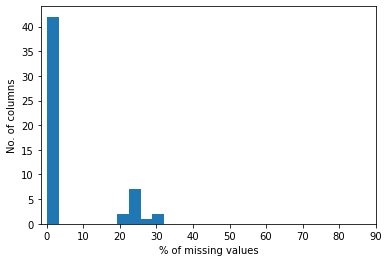

In [47]:
# We plot another histogram to see if there is any clear outliers
df_column_nan_2 = df.isna().mean().sort_values(ascending=False)*100
# Histogram of amount of missing data
plt.hist(df_column_nan_2)
plt.xticks(np.arange(0,100,10), [str(x) for x in np.arange(0,100,10)])
plt.xlabel('% of missing values')
plt.ylabel('No. of columns');

#### Comments:

From the above histogram, we see that it is obvious we remove every column with more than say 18% of missing values.

In [48]:
removed_columns_4 = df_column_nan_2[df_column_nan_2 > 10].index
removed_columns_4

Index(['host_response_time', 'host_response_rate', 'security_deposit',
       'review_scores_location', 'review_scores_value',
       'review_scores_checkin', 'review_scores_accuracy',
       'review_scores_communication', 'review_scores_cleanliness',
       'review_scores_rating', 'reviews_per_month', 'cleaning_fee'],
      dtype='object')

In [49]:
df.drop(removed_columns_4, axis=1, inplace=True)

In [50]:
df.shape

(11339, 42)

In [51]:
df.isna().sum().sum()

66

In [52]:
df['price'].isna().sum()

0

## Step 2: Answering of questions

In this step, we use the data to give answers to the four questions we posed at the begin. 

### Question 1: Is there any seasonal variability in prices and room availability?

Our first question was to see if there is any seasonal variability in room availability and price. Since room price vary significantly by room type. I thought it would make more sense to answer this question based on room type.

In [53]:
df_listing = df

In [54]:
df_listing['room_type'].isna().sum()

0

In [55]:
listing_type = df_listing['room_type'].value_counts(normalize=True)*100

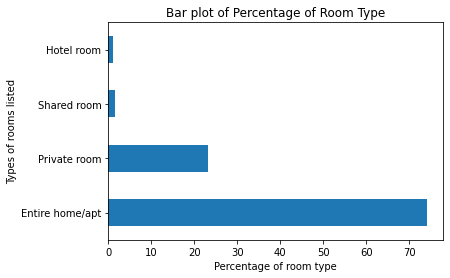

In [56]:
listing_type.plot(kind='barh');
plt.title('Bar plot of Percentage of Room Type')
plt.ylabel('Types of rooms listed')
plt.xlabel('Percentage of room type');

In [57]:
# Get the listing id's of the different room types
df_listing_entire_id = df_listing['id'][df_listing['room_type'] == 'Entire home/apt']
df_listing_private_id = df_listing['id'][df_listing['room_type'] == 'Private room']
df_listing_shared_id = df_listing['id'][df_listing['room_type'] == 'Shared room']
df_listing_hotel_id = df_listing['id'][df_listing['room_type'] == 'Hotel room']

In [58]:
# extra the calendar listings of each of the room type
df_calendar_entire = df_calendar[df_calendar['listing_id'].isin(df_listing_entire_id)]
df_calendar_private = df_calendar[df_calendar['listing_id'].isin(df_listing_private_id)]
df_calendar_shared = df_calendar[df_calendar['listing_id'].isin(df_listing_shared_id)]
df_calendar_hotel = df_calendar[df_calendar['listing_id'].isin(df_listing_hotel_id)]

In [59]:
# Percentage of available listings for "entire home"
entire_avail_perc = df_calendar_entire.groupby('month')['available'].mean()*100

In [60]:
# Percentage of available listings for "private room"
private_avail_perc = df_calendar_private.groupby('month')['available'].mean()*100

In [61]:
# Percentage of available listings for "shared room"
shared_avail_perc = df_calendar_shared.groupby('month')['available'].mean()*100

In [62]:
# Percentage of available listings for "hotel room"
hotel_avail_perc = df_calendar_hotel.groupby('month')['available'].mean()*100

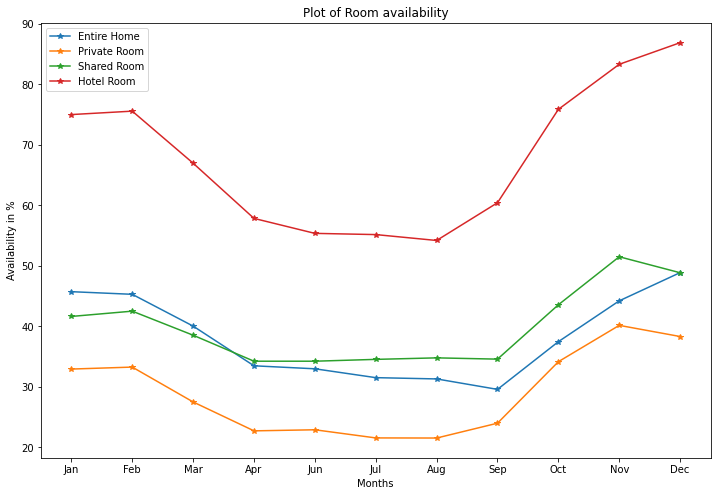

In [217]:
fig = plt.figure(10, figsize=(12,8))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
availability_entire = [entire_avail_perc[month] for month in months]
availability_private = [private_avail_perc[month] for month in months]
availability_shared = [shared_avail_perc[month] for month in months]
availability_hotel = [hotel_avail_perc[month] for month in months]

plt.plot(months, availability_entire, '*-', label='Entire Home')
plt.plot(months, availability_private, '*-', label='Private Room')
plt.plot(months, availability_shared, '*-', label='Shared Room')
plt.plot(months, availability_hotel, '*-', label='Hotel Room')

plt.xlabel('Months')
plt.ylabel('Availability in %')
plt.title(f'Plot of Room availability');
plt.legend()
plt.show()

### Answer 1a and 2: 

From the figures shown above, we see that there is a seasonal variability in room availability in Austin. Room availability (for the four room types) is generally low in the months of April - September, whereas there is more availability of rooms in October - December. 

The busiest time to visit Austin will obviously be between April - September, as room availability is very low.

In [66]:
# Average of price for different room types
avg_price_entire = df_calendar_entire.groupby('month')['price'].mean()
avg_price_private = df_calendar_private.groupby('month')['price'].mean()
avg_price_shared = df_calendar_shared.groupby('month')['price'].mean()
avg_price_hotel = df_calendar_hotel.groupby('month')['price'].mean()

In [67]:
# function to plot prices

def plot_prices(df, type):
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    availability = [df[month] for month in months]
    plt.plot(months, availability, '*-b')
    plt.xlabel('Months')
    plt.ylabel('Average Price in $')
    plt.title(f'Plot of {type} average price');

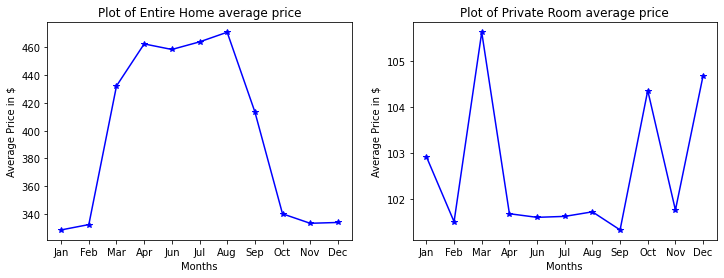

In [68]:
fig = plt.figure(10, figsize=(12,4))

ax1 = fig.add_subplot(121)
plot_prices(avg_price_entire, 'Entire Home')

ax2 = fig.add_subplot(122)
plot_prices(avg_price_private, 'Private Room')



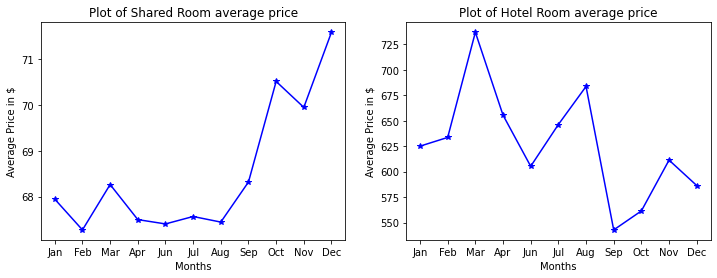

In [69]:
fig = plt.figure(10, figsize=(12,4))

ax3 = fig.add_subplot(121)
plot_prices(avg_price_shared, 'Shared Room')

ax4 = fig.add_subplot(122)
plot_prices(avg_price_hotel, 'Hotel Room')

### Answer 1b: 

There isnt much variability in the price for *Private Rooms* and *Shared Rooms*, as we can see from the plot that the difference between the maximum and minimum average prices arent significant. 

For Entire homes, prices are usually high between April and August, and lowest in January, February, October - December, whereas for Hotel Room, proces are high in March and lowest in September.

### Question 2:

We can answer question 2 using a different analysis. We can plot a bar chat of the number of listings available in each month using the `df_calendar` dataframe.

In [70]:
# Groupby "months", and then count the number of availability
month_availability = df_calendar.groupby('month')['available'].sum()

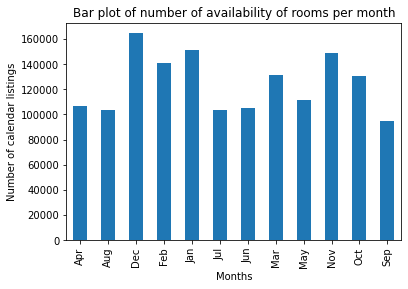

In [222]:
month_availability.plot(kind='bar', sort_columns=True);
plt.title('Bar plot of number of availability of rooms per month')
plt.ylabel('Number of calendar listings')
plt.xlabel('Months');

In [72]:
month_availability

month
Apr    106350
Aug    103174
Dec    164602
Feb    140681
Jan    151180
Jul    103761
Jun    105157
Mar    131456
May    111717
Nov    149007
Oct    130773
Sep     94373
Name: available, dtype: int64

In [73]:
month_availability[month_availability < 105000].index

Index(['Aug', 'Jul', 'Sep'], dtype='object', name='month')

### Answer 2:

From these we see that it is very busy to visit Austin in **April**, **July** and **September**.

### Question 3:

We use heatmap and correlation to see properties that are associated with high prices.

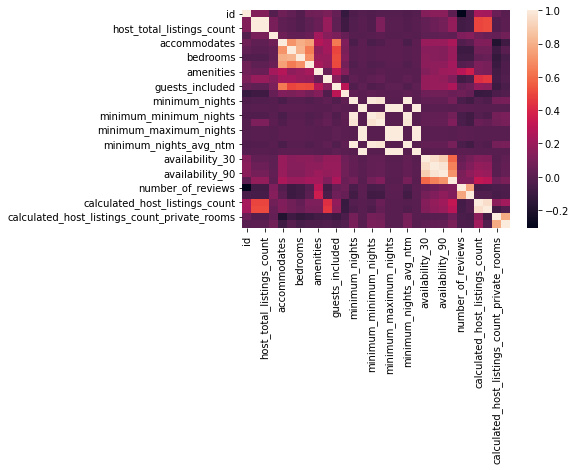

In [74]:
import seaborn as sns

sns.heatmap(df_listing.corr());

### Comments:

For some weired reasons, heatmap didnt show the correlation between all continuous columns. So in the next column, I select the column that pertains to correlation with price and sort in descending order.

In [75]:
df_listing.corr()['price'].sort_values(ascending=False)

price                                           1.000000
calculated_host_listings_count_entire_homes     0.450575
calculated_host_listings_count                  0.428560
bathrooms                                       0.225785
accommodates                                    0.221489
bedrooms                                        0.192215
availability_60                                 0.188742
host_listings_count                             0.187700
host_total_listings_count                       0.187700
availability_30                                 0.178892
beds                                            0.178774
availability_90                                 0.176070
host_verifications                              0.136990
guests_included                                 0.133505
availability_365                                0.114837
id                                              0.102770
amenities                                       0.041944
maximum_minimum_nights         

### Answer 3:

From the above, we see that `calculated_host_listings_count_entire_homes`, `calculated_host_listings_count`, `bathrooms` and `accommodates` have more than 20% correlation with the price of a listing.

Note that when we use `.corr`, it neglects the categorical features. So the above analysis is for the featuures among the continuous ones that relate to high prices.

### Question 4:

In this last question, we try to see if we can predict the price of an airbnb rental using the listing column. To do this, we create a function that will help to clean up the data and do the prediction using linear regression.

In [76]:
df_listing.columns

Index(['id', 'host_since', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
     

In [77]:
df_listing.select_dtypes(include=['object'])

,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,property_type,room_type,bed_type,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,08-09,t,t,t,f,House,Entire home/apt,Real Bed,f,strict_14_with_grace_period,f,f
1,08-09,t,t,t,t,House,Private room,Real Bed,f,strict_14_with_grace_period,f,f
2,08-09,t,t,t,t,House,Entire home/apt,Real Bed,f,strict_14_with_grace_period,f,t
3,08-09,t,t,t,t,House,Private room,Real Bed,f,moderate,t,t
4,08-09,t,t,f,t,House,Entire home/apt,Real Bed,t,strict_14_with_grace_period,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...
11334,16-17,f,t,f,t,Apartment,Entire home/apt,Real Bed,f,flexible,f,f
11335,14-15,f,t,f,f,Apartment,Entire home/apt,Real Bed,f,flexible,f,f
11336,18-19,f,t,f,f,Apartment,Private room,Real Bed,t,flexible,f,f
11337,14-15,t,t,f,t,House,Entire home/apt,Real Bed,t,flexible,f,f


In [78]:
df_listing.select_dtypes(exclude=['object'])

,id,host_listings_count,host_total_listings_count,host_verifications,accommodates,bathrooms,bedrooms,beds,amenities,price,...,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,2265,3.0,3.0,5,4,2.0,2.0,2.0,38,225.0,...,0,0,0,0,24,1,3,2,1,0
1,5245,3.0,3.0,5,2,1.0,1.0,2.0,27,100.0,...,11,11,11,11,9,0,3,2,1,0
2,5456,1.0,1.0,4,3,1.0,1.0,2.0,29,95.0,...,2,11,35,291,499,46,1,1,0,0
3,5769,1.0,1.0,6,2,1.0,1.0,1.0,22,40.0,...,6,6,13,13,253,16,1,0,1,0
4,6413,1.0,1.0,8,2,1.0,NaN,1.0,22,99.0,...,0,0,0,0,100,23,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11334,38726612,2.0,2.0,2,8,2.0,2.0,4.0,20,400.0,...,14,44,74,74,0,0,2,2,0,0
11335,38727516,1.0,1.0,2,2,1.0,1.0,1.0,20,55.0,...,24,54,84,359,1,1,1,1,0,0
11336,38728146,1.0,1.0,2,2,1.0,1.0,1.0,14,50.0,...,11,11,11,11,0,0,1,0,1,0
11337,38728874,1.0,1.0,4,2,1.0,1.0,1.0,29,455.0,...,10,10,11,11,0,0,3,2,1,0


In [79]:
# We drop the "id" column.
df_listing.drop('id', axis=1, inplace=True)

In [80]:
df_listing.shape

(11339, 41)

In [613]:
def clean_fit_linear_mod(df, response_col, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    
    #Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)


    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]
    
    # Fill numeric columns with the mean
    num_vars = X.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        X[col].fillna((X[col].mean()), inplace=True)
    
    
    # Create dummy columns for all the categorical variables in X, drop the original columns
    cat_cols = X.select_dtypes(include=['object']).columns
    
    for col in cat_cols:
        try:
            X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, drop_first=True)], axis=1)
        except:
            continue

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    
    s = StandardScaler() # Instantiate
    X_train_s = s.fit_transform(X_train)

    lm_model = LinearRegression() # Instantiate
    lm_model.fit(X_train_s, y_train) #Fit

    #Predict using your model
    X_test_s = s.transform(X_test)
    y_test_preds = lm_model.predict(X_test_s)
    y_train_preds = lm_model.predict(X_train_s)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df, 'price')

In [202]:
#Drop the rows with missing response values
df  = df_listing.dropna(subset=['price'], axis=0)

#Drop columns with all NaN values
df = df_listing.dropna(how='all', axis=1)


#Split into explanatory and response variables
X = df_listing.drop('price', axis=1)
y = df_listing['price']
    
# Fill numeric columns with the mean
num_vars = X.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    X[col].fillna((X[col].mean()), inplace=True)
    
    
# Create dummy columns for all the categorical variables in X, drop the original columns
cat_cols = X.select_dtypes(include=['object']).columns
    
for col in cat_cols:
    try:
        X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, drop_first=True)], axis=1)
    except:
        continue

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=18)
    


In [203]:
rf = RandomForestRegressor(n_estimators = 200, max_features = 'sqrt', 
                           max_depth = 20, random_state = 18).fit(X_train, y_train)


In [204]:
train_prediction = rf.predict(X_train)

In [205]:
test_prediction = rf.predict(X_test)

In [206]:
train_score = r2_score(y_train, train_prediction)
train_score

0.9767725587924461

In [207]:
test_score = r2_score(y_test, test_prediction)
test_score

0.7804796716187358

In [208]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.9767725587924461.  The rsquared on the test data was 0.7804796716187358.


#### Comments:

The code below to get feature importances is gotten from https://towardsdatascience.com/random-forest-in-python-24d0893d51c0


In [212]:
    
# get feature list
feature_list = list(X.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: calculated_host_listings_count Importance: 0.14
Variable: host_total_listings_count Importance: 0.12
Variable: calculated_host_listings_count_entire_homes Importance: 0.12
Variable: host_listings_count  Importance: 0.1
Variable: host_verifications   Importance: 0.04
Variable: bathrooms            Importance: 0.03
Variable: availability_90      Importance: 0.03
Variable: cancellation_policy_moderate Importance: 0.03
Variable: accommodates         Importance: 0.02
Variable: bedrooms             Importance: 0.02
Variable: amenities            Importance: 0.02
Variable: extra_people         Importance: 0.02
Variable: minimum_minimum_nights Importance: 0.02
Variable: minimum_nights_avg_ntm Importance: 0.02
Variable: availability_60      Importance: 0.02
Variable: availability_365     Importance: 0.02
Variable: number_of_reviews    Importance: 0.02
Variable: cancellation_policy_strict_14_with_grace_period Importance: 0.02
Variable: beds                 Importance: 0.01
Variable: gu